# Signal detection simulation

Translation of Justin's [Signal Detection Tutorial](http://gru.stanford.edu/doku.php/tutorials/sdt) from MATLAB to Python.

We're going to simulate a signal detection experiment and an “ideal observer” (an observer who behaves exactly according to signal detection theory). This is always a useful thing to do when trying to understand a decision model, experimental method or an analysis tool. You get to control and play around with the simulation to see what effect it has on the analysis that comes out.


On each trial, our observer sees an element sampled from either the signal present gaussian distribution or the signal absent distribution, which is also gaussian with the same standard deviation. The observer chooses to say “signal present” when the signal they see on that trial is above criterion and “signal absent” otherwise. The picture you 
should have in your head is this:

<img src=http://gru.stanford.edu/lib/exe/fetch.php/tutorials/nobias.png?w=&h=&cache=cache>



In [1]:
%matplotlib inline

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Make `signal_present` array

So, here goes. First let's make a sequence of n = 1000 trials in which 50% randomly are going to have “signal” and 50% are randomly going to have no signal. To do that we want to create an array called `signal_present` that is True 50% of the time and False 50% of the time.

In [3]:
signal_present = np.random.rand(1000) > .5

We can make a heatmap to show the binary values:

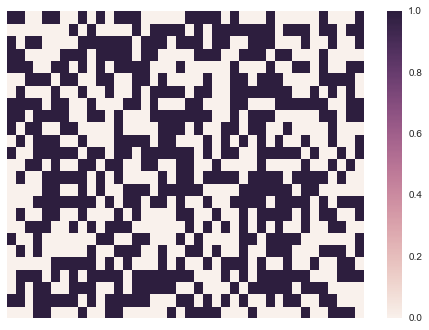

In [4]:
sns.heatmap(signal_present.reshape(25, 40), linewidths=0, xticklabels=False, yticklabels=False);

## Make signal array 

Ok, now we want to simulate the **signal** that the observer actually gets to base the decision on. Remember that in applying signal detection to cognitive neuroscience you should be thinking of the signal as a neuron or population of neurons response and that the magnitude of this response (e.g. spikes per second) is monotonically related to the actual signal strength. The signal is corrupted by random noise. In particular, signal trials should come from some gaussian distribution and noise trials should come from another gaussian distribution that differ only in the means. This is an assumption about the process that is termed $iid$ - the signal and noise come from independent identical distributions.

Ok, let's make a new array from our `signal_present` array such that on signal present trials (i.e. when `signal_present == 1`), values are picked from a gaussian distribution with standard deviation of 1 who's mean is 1 and on signal absent trials (i.e. when `signal_present == 0`), values are picked from a gaussian distribution with standard deviation of 1 (that's the identical part of the $iid$ assumption) but who's mean is 0.

In [5]:
signal = np.random.normal(0, 1, size=signal_present.size)
signal[signal_present] = np.random.normal(1, 1, size=signal_present.sum())

We can look at a heatmap of the signal values:

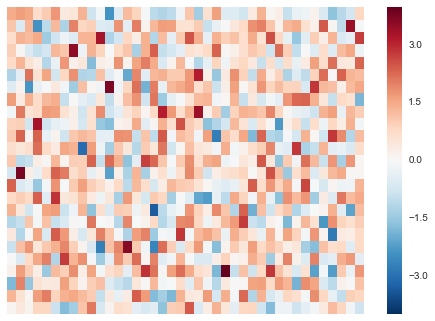

In [6]:
sns.heatmap(signal.reshape(25, 40), linewidths=0, xticklabels=False, yticklabels=False);

This is somewhat helpful, but it doesn't really show us the distribution of values. To do that, let's make a histogram and density plot.

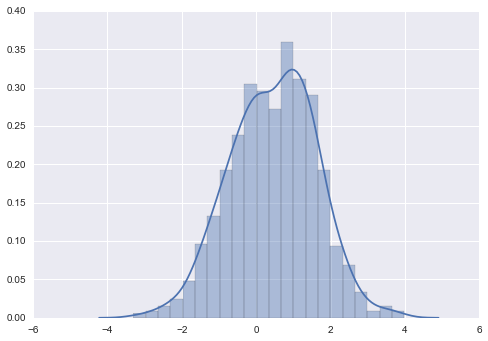

In [7]:
sns.distplot(signal);

That's weird, it only has one peak, centered roughly around 0.5. Why? Shouldn't we have one peak at 0 and one peak at 1 for the signal present and absent trials? Yeah, but because they are so close together you can't really see them. You can see them separately if you display the histogram for just the signal present or just the signal absent trials.

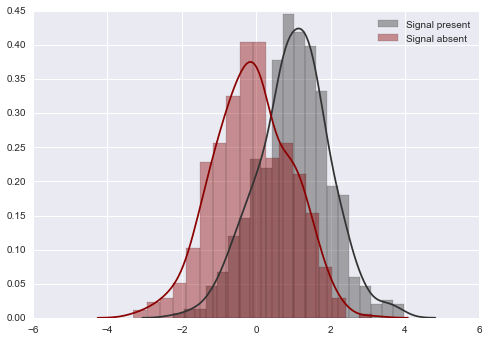

In [8]:
sns.distplot(signal[signal_present], color=".2", label="Signal present")
sns.distplot(signal[~signal_present], color="darkred", label="Signal absent")
plt.legend();

Now confirm numerically that the means and standard deviations are what they should be:

In [9]:
print("Signal present mean: {:.2f}".format(signal[signal_present].mean()))
print("Signal absent mean: {:.2f}".format(signal[~signal_present].mean()))

Signal present mean: 1.00
Signal absent mean: -0.10


Ok, we're good to go. We have created the stimulus that our ideal observer will get to see (`signal`) and we know which of the trials come from the signal and which from the absent distributions (`signal_present`).

## Make ideal observer responses

Now we are going to simulate an *ideal observer* which will behave just as signal detection says. They will choose signal present (response = 1) when the signal they get to see (signal array from above) is greater than their internal criterion and they will choose signal absent (response = 0) when the signal is below their internal criterion.

Let's start by making the criterion right in between the signal present and absent distributions that we created above. That is, let's set criterion to 0.5 and make an array of responses:

In [10]:
response = signal > .5

Let's make a heatmap like before

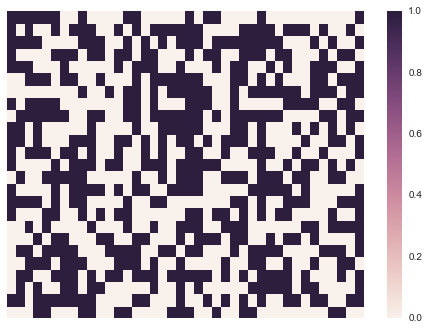

In [11]:
sns.heatmap(response.reshape(25, 40), linewidths=0, xticklabels=False, yticklabels=False);

Again, not too informative, but it would help us catch strange cases like response always being `True`, which might indicate a problem in the code.

## Calculate hits, misses, correct-rejects and false-alarms

Ok, so now we have our experiment (`signal_present`) a simulation of the signal it generates in the observer (`signal`) and the ideal observers responses (`response`).

From these you should be able to calculate hits, misses, correct rejects and false alarms.


In [12]:
hit = response[signal_present]
miss = ~response[signal_present]
fa = response[~signal_present]
cr = ~response[~signal_present]

In [13]:
print("Hit rate: {:.2f}".format(hit.mean()))
print("Miss rate: {:.2f}".format(miss.mean()))
print("False alarm rate: {:.2f}".format(fa.mean()))
print("Correct rejection rate: {:.2f}".format(cr.mean()))

Hit rate: 0.71
Miss rate: 0.29
False alarm rate: 0.27
Correct rejection rate: 0.73


## Calculate $d'$

Now let's calculate $d'$. But, first a pop quiz: what should $d'$ be given how we made the signal and noise distributions?

Answer: (mean of signal - mean of noise) / standard deviation = (1 - 0) / 1 = 1

The picture you should have is:

<img src=http://gru.stanford.edu/lib/exe/fetch.php/tutorials/neuraldprime.png>

Ok, now we know what it should be, we're ready for pop quiz 2: what's the formula for computing $d'$ from behavioral data?

$$d' = z(\textrm{hits}) - z(\textrm{false alarms})$$

So, how do we calculate those $z$'s?

$z$ means the distance in units of standard deviation from the center of a gaussian distribution such that the area under the curve to the right of that is the proportion hits or false alarms that we measured in the experiment. By convention, center of the distribution is 0, and criterion to the left are positive. The picture you should have for example if $z$ is 1 (giving an area under the curve to the right of that of 0.84 is):

<img src=http://gru.stanford.edu/lib/exe/fetch.php/tutorials/zof1.png>

To get this area you can use the `stats.norm.ppf()` function which gives the inverse of the cumulative density function. It's the cumulative density function since you are interested in the area under the gaussian probability density function, and its the inverse since you are going from the area, back to the $z$ (units of std of the gaussian).

In [14]:
from scipy import stats
dprime = stats.norm.ppf(hit.mean()) - stats.norm.ppf(fa.mean())
print("d prime: {:.2f}".format(dprime))

d prime: 1.16


How close is the dPrime you got to the expected value? Why is it different?

## Different criterion

Now let's simulate an observer that doesn't want to miss as much and see if we get a similar $d'$ from the data.

In [15]:
response = signal > .2

In [16]:
hit = response[signal_present]
fa = response[~signal_present]
dprime = stats.norm.ppf(hit.mean()) - stats.norm.ppf(fa.mean())
print("d prime: {:.2f}".format(dprime))

d prime: 1.15


## ROC calculation

Now, let's make an ROC curve. This assumes that we have some examples of samples from the signal and noise distributions. In the Newsome experiments these are the values of the spike counts for the neurons preferred direction (signal) and the neurons anti-preferred direction (noise, what they called the anti-neuron). Will just do it by pulling actual values from a signal distribution that is gaussian with mean of 1 and standard deviation of 1, just like we did above. For the noise, let's do mean of 0 and standard deviation of 1. Make two arrays of length n = 1000, one for signal and noise using the techniques from above:

In [17]:
n = 1000
signal = np.random.normal(1, 1, n)
noise = np.random.normal(0, 1, n)

Check that the procedure worked by computing the means and standard deviations of signal and noise and making sure that they are what you expected (always good to double check everything when programming to make sure that things are working out the way you expected).

In [18]:
print("Signal mean +/- std: {:.2f} ({:.2f})".format(signal.mean(), signal.std()))
print("Noise mean +/- std: {:.2f} ({:.2f})".format(noise.mean(), noise.std()))

Signal mean +/- std: 0.98 (0.97)
Noise mean +/- std: -0.04 (1.01)


It's also helpful to make plots like we did above:

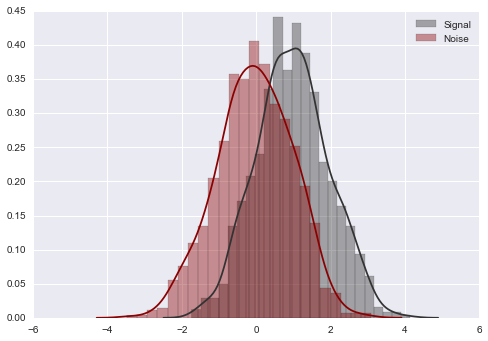

In [19]:
sns.distplot(signal, color=".2", label="Signal")
sns.distplot(noise, color="darkred", label="Noise")
plt.legend()

Ok, how do we compute the ROC curve? What's on those two axes. Remember?

<img src=http://gru.stanford.edu/lib/exe/fetch.php/tutorials/basicroc.png>

Ok, so that is computed for various criterions, right? So, if you think you know how, try to compute a curve from the signal and noise distributions.



In [20]:
criterions = np.linspace(10, -10, 100)
hit_rates = [(signal > c).mean() for c in criterions]
fa_rates = [(noise > c).mean() for c in criterions]

Ok, now plot it:

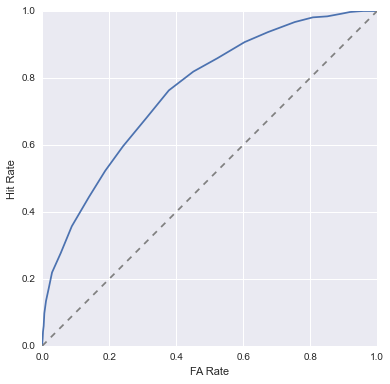

In [21]:
f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fa_rates, hit_rates)
ax.plot([0, 1], [0, 1], ls="--", c=".5")
ax.set(xlabel="FA Rate", ylabel="Hit Rate");

And, remember that the area under the ROC is performance on a two alternative forced choice task (2AFC). So, calculate the area under the curve and see what you get.

In [22]:
from scipy.integrate import trapz
auc = trapz(hit_rates, fa_rates)
print("Area under ROC curve: {:.2f}".format(auc))

Area under ROC curve: 0.76


What did you get? Is it right? Well, one way to check is to see if a simulation of 2AFC will give you the same (or numerically similar) values. The experimental logic says that if signal is greater than noise then the ideal observer will get the 2AFC right, otherwise the observer will choose the noise interval and get it wrong. So, that's pretty easy to simulate. Try it!

In [23]:
afc_perf = (signal > noise).mean()
print("2AFC performance: {:.2f}".format(afc_perf))

2AFC performance: 0.75
